In [1]:
import numpy as np
import matplotlib.pyplot as plt
from load_MNIST import MnistDataloader
from os.path import join
import random
%matplotlib inline
np.random.seed(1)

Number of training examples in training set : 60000
Number of training examples in test set : 10000
size of each image : 28*28


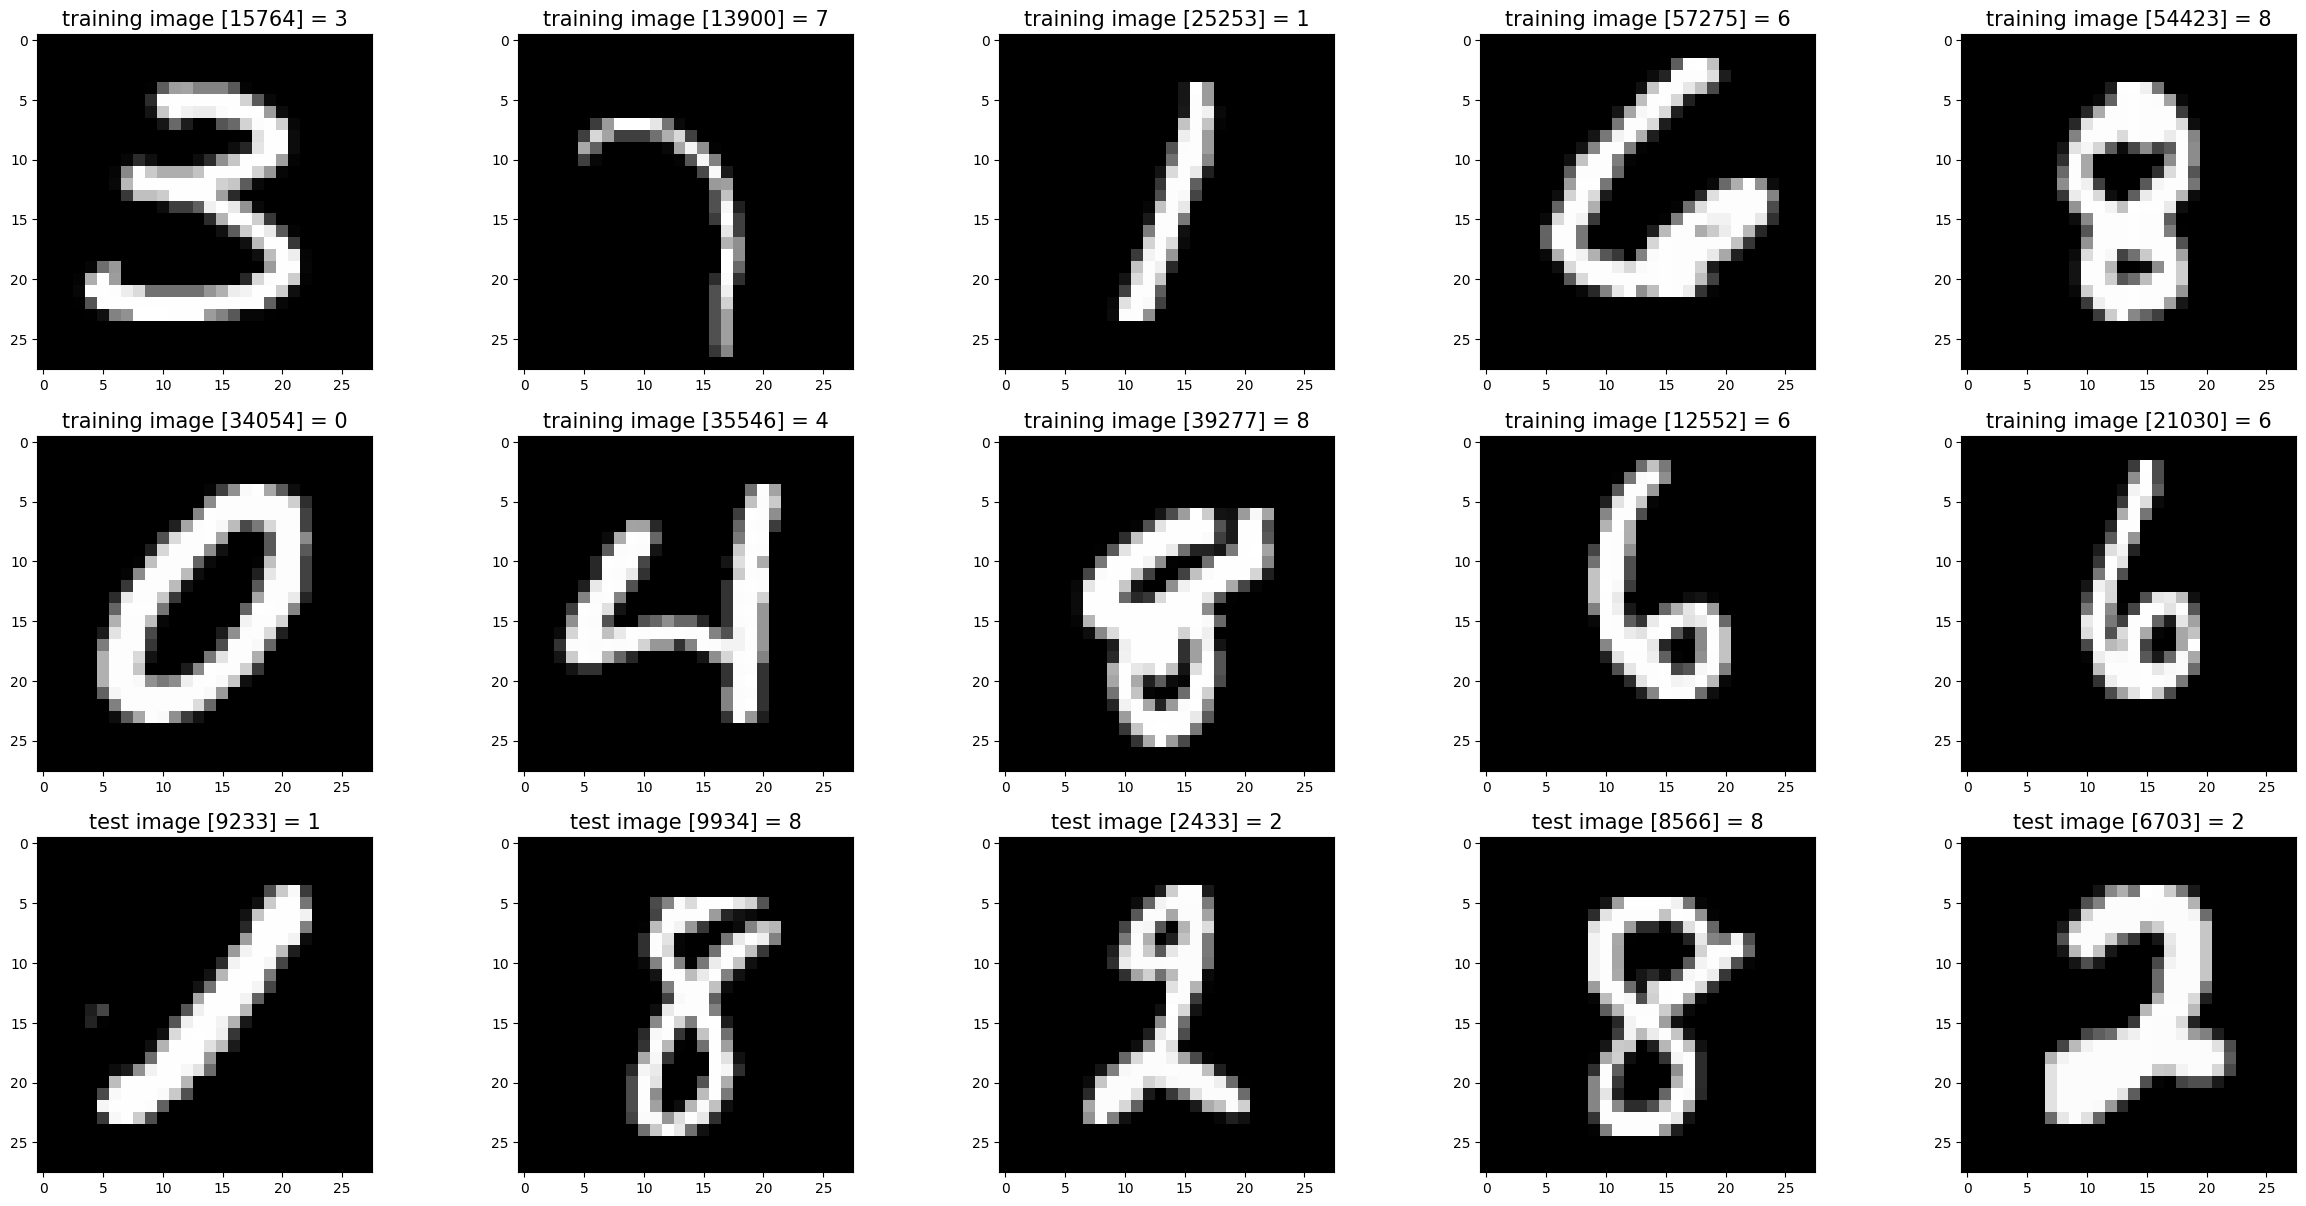

In [2]:
#Loading MNIST dataset
input_path = 'datasets/MNIST_dataset/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

m_train = len(x_train)
m_test = len(x_test)
num_pixel = len(x_train[0])

print(f"Number of training examples in training set : {m_train}")
print(f"Number of training examples in test set : {m_test}")
print(f"size of each image : {num_pixel}*{num_pixel}")

In [3]:
#unrolling the training and testing data
x_train = np.array(x_train).reshape((60000, 28*28)).T / 255.0
x_test = np.array(x_test).reshape((10000, 28*28)).T / 255.0    

y_train = np.array(y_train).reshape((1, 60000))  
y_test = np.array(y_test).reshape((1, 10000))   

In [4]:
def relu(Z):
    return np.maximum(Z,0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def d_relu(Z):
    return Z>0

def one_hot_encoding(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [5]:
def initialize_parameters(layer_dims):
    L = len(layer_dims)

    parameters = {}
    for l in range(1,L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l],1))

    return parameters

In [6]:
def forward_propogation_layer(W,b,A_prev,activation,keep_prob):

    Z = np.dot(W,A_prev) + b
    if activation == "relu":
        A = relu(Z)
    elif activation == "softmax":
        A = softmax(Z)

    D = np.random.rand(A.shape[0],A.shape[1])
    D = (D < keep_prob).astype(int)
    A = A*D
    A = A/keep_prob
    
    linear_cache = (W,b,A_prev)
    activation_cache = (Z,)
    dropout_cache = (D,)
    
    return A,(linear_cache, activation_cache,dropout_cache)

In [7]:
def forward_propogation(X,parameters,keep_prob):
    L = len(parameters)//2
    caches = []
    A = X
    
    for l in range(1,L):
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        A,cache = forward_propogation_layer(W,b,A,"relu",keep_prob)
        caches.append(cache)

    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    AL,cache = forward_propogation_layer(W,b,A,"softmax",1)
    caches.append(cache)
    
    return AL,caches

In [8]:
def compute_cost(Y,AL,parameters,lambd):
    Y = one_hot_encoding(Y)
    m = Y.shape[1]
    L = len(parameters)//2
    regularization_cost = 0
    
    for l in range(1,L+1):
        regularization_cost += (lambd/(2*m))*np.sum(np.square(parameters[f"W{l}"]))
        
    cost = (-np.sum(Y * np.log(AL + 1e-8)) / m) + (regularization_cost)  
    return float(np.squeeze(cost))

In [9]:
def backpropogation_layer(dA,c_cache,activation,m, lambd,keep_prob):
    linear_cache = c_cache[0]
    activation_cache = c_cache[1]
    dropout_cache = c_cache[2]

    grad = {}
    
    W = linear_cache[0]
    b = linear_cache[1]
    A_prev = linear_cache[2]
    
    Z = activation_cache[0]

    D = dropout_cache[0]

    dA = dA*D
    dA = dA/keep_prob
    
    if activation == "relu":
        dZ = dA*d_relu(Z)
    if activation == "softmax":
        dZ = dA
    dW = np.dot(dZ,A_prev.T)/m + (lambd/m)*W
    db = np.sum(dZ, axis=1, keepdims = True)/m
    dA = np.dot(W.T,dZ)    

    grad["dW"] = dW
    grad["db"] = db

    return dA,grad

In [10]:
def backpropogation(AL, caches,Y,lambd,keep_prob):
    L = len(caches)
    m = Y.shape[1]
    grads = {}
    one_hot_Y = one_hot_encoding(Y)
    dA = AL - one_hot_Y
    c_cache = caches[L-1]
    dA, grad = backpropogation_layer(dA,c_cache,"softmax",m,lambd,1)

    grads[f"dW{L}"] = grad["dW"]
    grads[f"db{L}"] = grad["db"]
    
    for l in range(L-2,-1,-1):
        c_cache = caches[l]
        dA, grad = backpropogation_layer(dA,c_cache,"relu",m,lambd,keep_prob)

        grads[f"dW{l + 1}"] = grad["dW"]
        grads[f"db{l + 1}"] = grad["db"]

    return grads
        

In [11]:
def update_parameters(grads, parameters, learning_rate):
    L = len(parameters)//2

    for l in range(1,L+1):
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]

        dW = grads[f"dW{l}"]
        db = grads[f"db{l}"]

        W = W - learning_rate*dW
        b = b - learning_rate*db

        parameters[f"W{l}"] = W
        parameters[f"b{l}"] = b

    return parameters

In [12]:
def predict(parameters,X,Y):
    A,_ = forward_propogation(X,parameters,1)
    prediction = np.argmax(A,0)
    accuracy = np.sum(prediction==Y)/A.shape[1]
    return accuracy,prediction

In [13]:
def model(X,Y,layer_dims,learning_rate,num_iterations,lambd,keep_prob,print_cost):
    m = X.shape[1]
    n = X.shape[0]
    parameters = initialize_parameters(layer_dims)

    J_cache = []
    for i in range(num_iterations):
        AL,caches = forward_propogation(X,parameters,keep_prob)
        J = compute_cost(Y,AL,parameters,lambd)
        grads = backpropogation(AL, caches, Y,lambd,keep_prob) 
        parameters = update_parameters(grads, parameters, learning_rate)

        prediction = np.argmax(AL,0)
        accuracy = np.sum(prediction==Y)/AL.shape[1]
        
        if i%100 == 0 and print_cost:
            print(f"Cost at iteration {i} : {J}, Accuracy of the model : {accuracy*100}%")
            J_cache.append(J)

    plt.plot(J_cache)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters
            

Cost at iteration 0 : 2.343975775605902, Accuracy of the model : 10.025%
Cost at iteration 100 : 0.6540465318054104, Accuracy of the model : 80.84166666666667%
Cost at iteration 200 : 0.4882770449158288, Accuracy of the model : 85.49833333333333%
Cost at iteration 300 : 0.4258392973152332, Accuracy of the model : 87.13666666666666%
Cost at iteration 400 : 0.38894076172897574, Accuracy of the model : 88.315%
Cost at iteration 500 : 0.36027060725167126, Accuracy of the model : 89.08833333333334%
Cost at iteration 600 : 0.34109474269691575, Accuracy of the model : 89.64833333333333%
Cost at iteration 700 : 0.32107927618673626, Accuracy of the model : 90.29833333333333%
Cost at iteration 800 : 0.30866303036338133, Accuracy of the model : 90.84333333333333%
Cost at iteration 900 : 0.2962943719942086, Accuracy of the model : 91.04166666666667%
Cost at iteration 1000 : 0.2859652911044183, Accuracy of the model : 91.33666666666667%


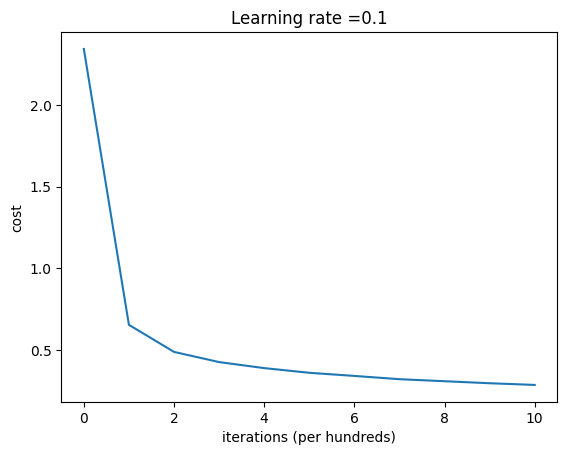

In [21]:
layer_dims = [num_pixel*num_pixel,25,15,10]
parameters = model(x_train,y_train,layer_dims,0.1,1001,0,0.95,True)

In [22]:
train_accuracy, train_prediction = predict(parameters, x_train, y_train)

In [23]:
print(f"Accuracy on training set : {train_accuracy*100}%")

Accuracy on training set : 94.13666666666667%


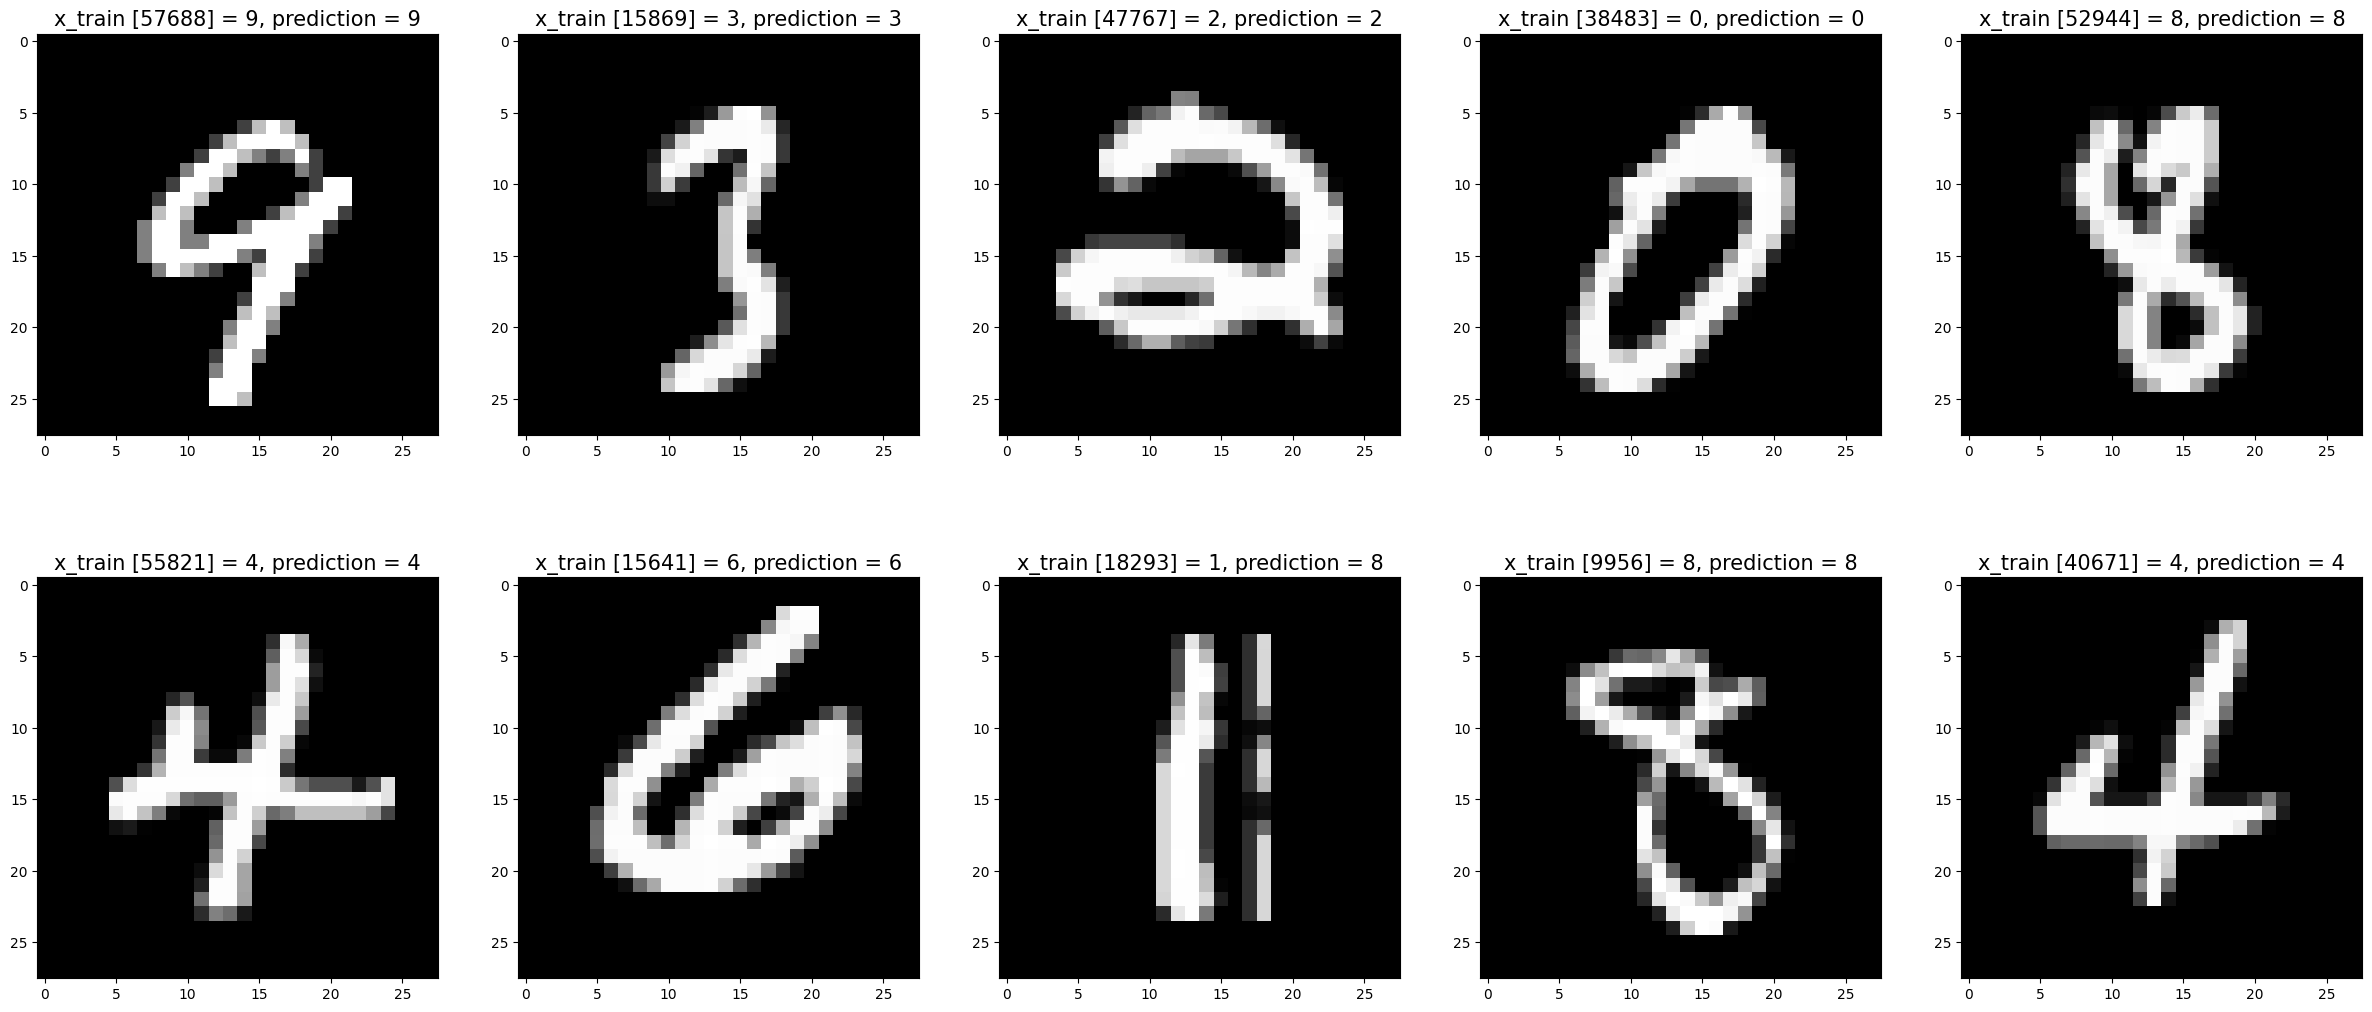

In [24]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, m_train)
    images_2_show.append(x_train[:,r].reshape((num_pixel,num_pixel)))
    titles_2_show.append('x_train [' + str(r) + '] = ' + str(y_train[0,r]) + ', prediction = ' + str(train_prediction[r]))    

show_images(images_2_show, titles_2_show)

In [25]:
test_accuracy,test_prediction = predict(parameters,x_test,y_test)

In [26]:
print(f"Accuracy on test set : {test_accuracy*100}%")

Accuracy on test set : 93.96%


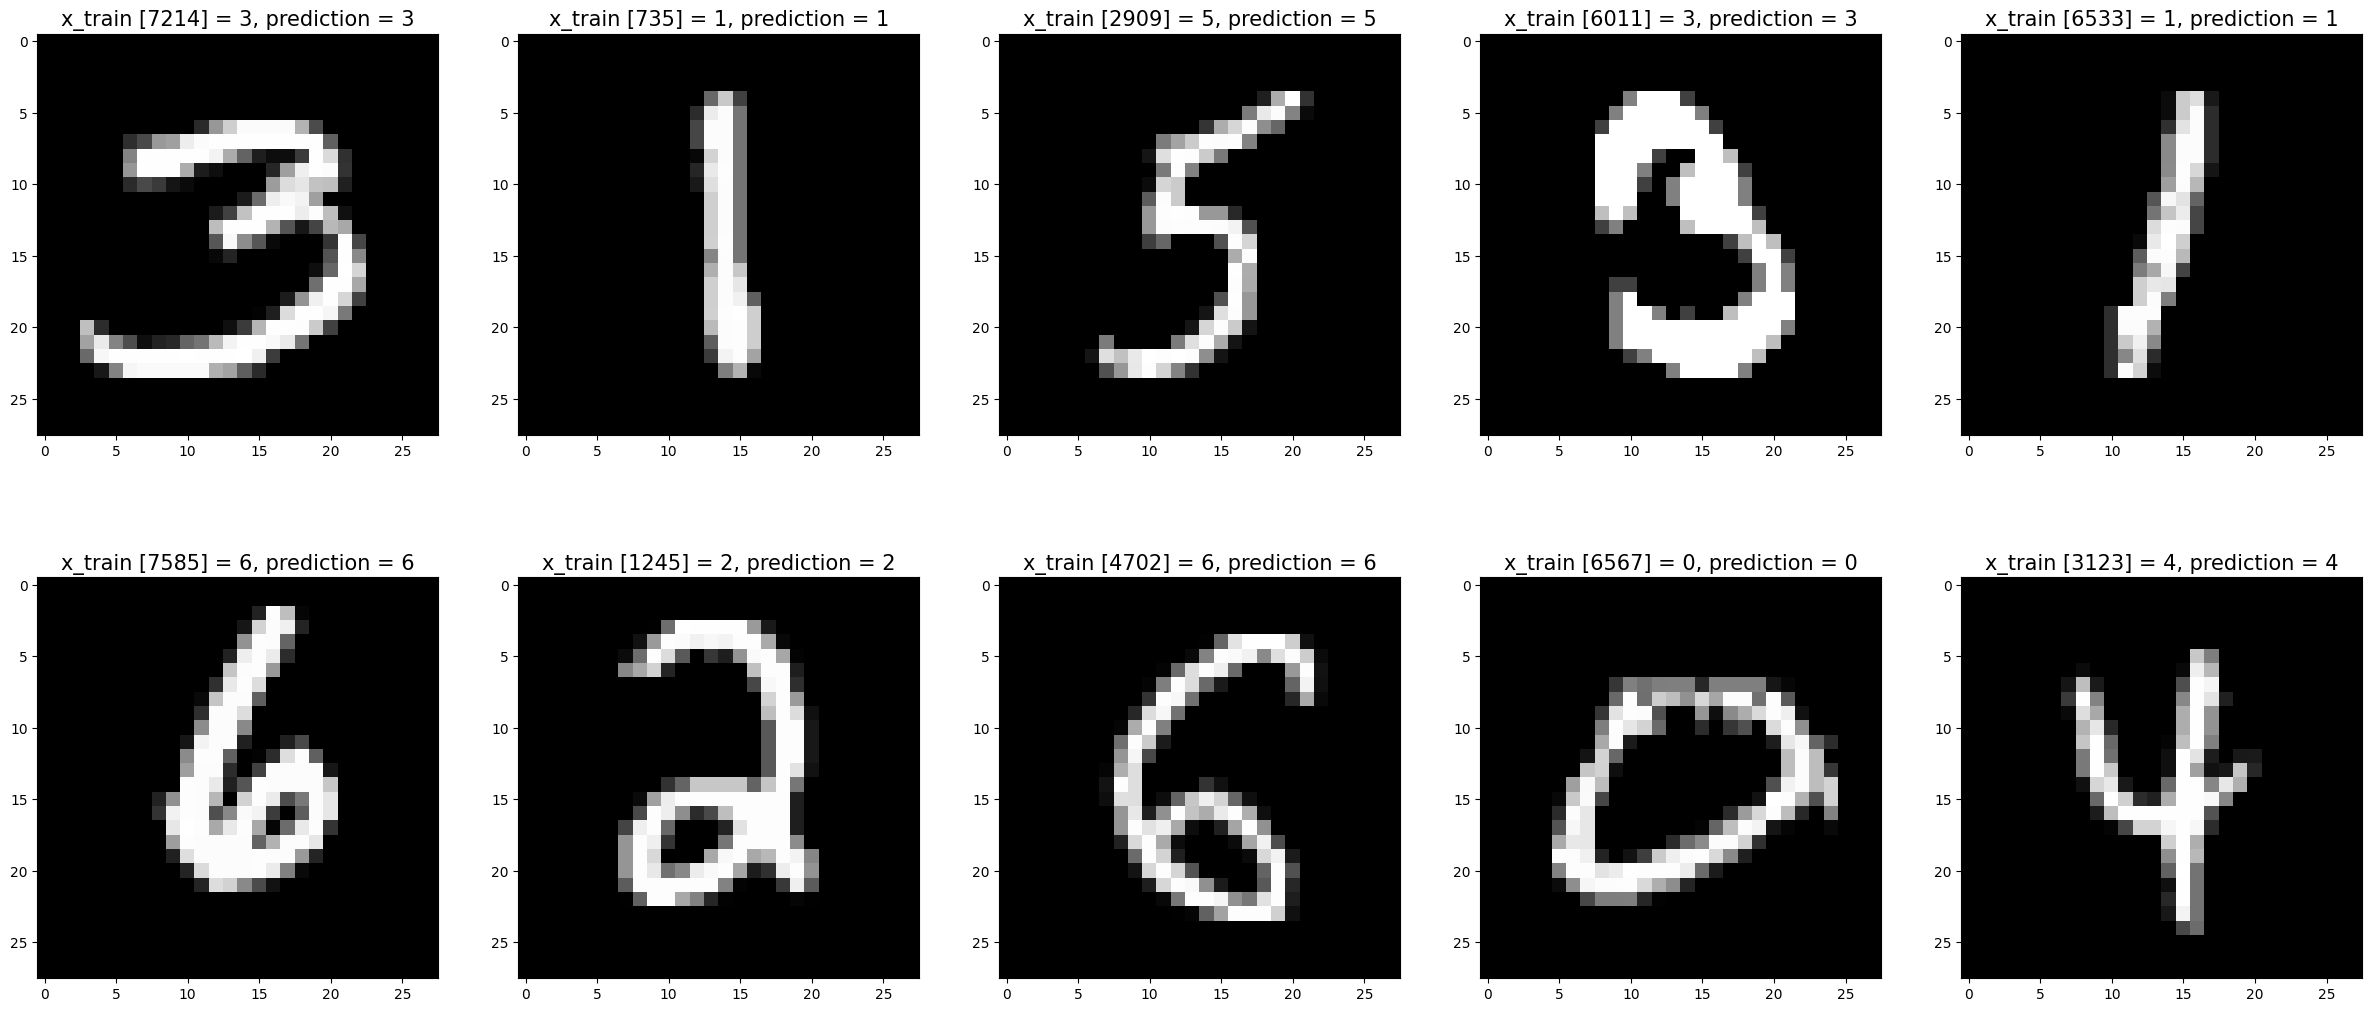

In [27]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, m_test)
    images_2_show.append(x_test[:,r].reshape((num_pixel,num_pixel)))
    titles_2_show.append('x_train [' + str(r) + '] = ' + str(y_test[0,r]) + ', prediction = ' + str(test_prediction[r]))    

show_images(images_2_show, titles_2_show)